# II. Data Preprocessing

In this notebook the different data sources are preprocessed, the variables defined in the report engineered and a master table to be used in the next sections is developed.

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt

import quandl

import statsmodels.api as sm
from scipy.stats import iqr

%matplotlib inline

## 0. Loading the data

Here we are going to use the following datasets:

    IBES Summary History - Summary history
    CRSP Monthly stock data
    FRED economic data (accessed directly and through Quandl API)
    World Bank (through Quandl API)
    Financial Ratios Suite (WRDS)

And load the ICLINK linking table to map CRSP to IBES:

In [2]:
# Loading the ICLINK linking table:
iclink = pd.read_csv('data/iclink.csv')

There are 121 construction stocks in the ddbb, with the following subclassification:

In [3]:
#iclink.groupby('DIV_DESC').TICKER.count()
iclink.loc[iclink.DIV == 'C'].groupby(['MG_DESC','IG_DESC']).TICKER.count().to_frame()

TICKER
MG_DESC                                            IG_DESC                                                 
Building Construction General Contractors And O... General Building Contractors-nonresidential            6
                                                   General Building Contractors-residential              23
                                                   Operative Builders                                    34
Construction Special Trade Contractors             Carpentry And Floor Work                               2
                                                   Electrical Work                                       11
                                                   Masonry, Stonework, Tile Setting, And Plastering       3
                                                   Miscellaneous Special Trade Contractors                7
                                                   Plumbing, Heating And Air-conditioning                 4
Heavy Construction Other Than Building Construc... Heavy Construction, Except Highway And Street         29
                                                   Highway And Street Construction, Except                2

### 0.1. Loading the IBES Summary History - Summary statistics


In [4]:
sumstat = pd.read_csv('data/sumstat_20y.csv')

In [5]:
# Drop the OFTIC and MEASURE column:
sumstat.drop(['OFTIC','MEASURE'], axis=1, inplace=True)

# Drop the rows where the ACTUAL value is NaN:
sumstat.dropna(subset=['ACTUAL'], inplace=True)

# Rename the columns:
sumstat = sumstat.rename(columns={'ANNDATS_ACT': 'ANNDT_ACT'})

In [6]:
# Set the date fields as timestamp:
sumstat.FPEDATS = pd.to_datetime(sumstat.FPEDATS, format="%d/%m/%Y")
sumstat.STATPERS = pd.to_datetime(sumstat.STATPERS, format="%d/%m/%Y")
sumstat.ANNDT_ACT = pd.to_datetime(sumstat.ANNDT_ACT, format="%d/%m/%Y")

In [7]:
# Keep only the cases when STATPERS preceeds ANNDT_ACT:
sumstat = sumstat.loc[sumstat.STATPERS < sumstat.ANNDT_ACT]

In [8]:
print('Interval of time covered: %s to %s' % (min(sumstat.FPEDATS),max(sumstat.FPEDATS)))
print('Number of Companies covered: %s' % sumstat.TICKER.nunique())
print('Shape of the dataset: %s' % str(sumstat.shape))

Interval of time covered: 1999-01-31 00:00:00 to 2019-01-31 00:00:00
Number of Companies covered: 12125
Shape of the dataset: (3421662, 14)


Add the industry classification:

In [9]:
# Add permno from iclink in order to combine IBES and CRSP datasets:
sumstat = sumstat.merge(iclink[['TICKER','MG']], on='TICKER', how='left')

In [10]:
sumstat.head()

,TICKER,STATPERS,FPI,NUMEST,NUMUP,NUMDOWN,MEDEST,MEANEST,STDEV,HIGHEST,LOWEST,FPEDATS,ACTUAL,ANNDT_ACT,MG
0,0000,2014-04-17,6,4,0,4,0.07,0.08,0.01,0.10,0.07,2014-03-31,0.12,2014-05-06,99.0
1,0000,2014-05-15,6,5,3,0,0.13,0.13,0.01,0.15,0.12,2014-06-30,0.27,2014-08-06,99.0
2,0000,2014-06-19,6,5,0,0,0.13,0.13,0.01,0.15,0.12,2014-06-30,0.27,2014-08-06,99.0
3,0000,2014-07-17,6,5,0,0,0.13,0.13,0.01,0.15,0.12,2014-06-30,0.27,2014-08-06,99.0
4,0000,2014-04-17,7,5,0,0,0.11,0.12,0.02,0.15,0.10,2014-06-30,0.27,2014-08-06,99.0


### 0.2. Loading CRSP monthly stock data

In [11]:
msf = pd.read_csv('data/msf_20y.csv')

In [12]:
# Rename the columns:
msf = msf.rename(columns={'PERMNO':'permno','SHRCD':'shrcd','PRC':'prc','RET':'ret','SHROUT':'shrout'})

# Convert to datetime object:
msf.date = pd.to_datetime(msf.date, format="%d/%m/%Y") + MonthEnd(0)

# Convert date of msf to end of month day, instead of last trading day of month, for merging purposes with IBES

In [13]:
# Keep only common share classes:
msf = msf.loc[msf.shrcd.isin([10,11])]
msf.drop('shrcd', axis=1, inplace=True)

In [14]:
# Keep only records with non missing ret, prc and shrout:
msf = msf[(msf['prc'].notna()) & (msf['ret'].notna()) & (msf['shrout'].notna())]
msf = msf.loc[msf.ret != 'C'] # Drop rows with C ret

# Change data format:
msf['permno'] = msf['permno'].astype(int)
msf['ret'] = msf['ret'].astype('float')

# Create Size, Month and Year columns
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['year'] = msf['date'].dt.year
msf['month'] = msf['date'].dt.month

In [15]:
# Add permno from iclink in order to combine IBES and CRSP datasets:
msf = msf.merge(iclink[['TICKER','PERMNO','MG']], left_on='permno', right_on='PERMNO', how='left')
msf.drop('PERMNO', axis=1, inplace=True)

# Print number of companies according to each ID:
print('Number of unique permno: %s' % msf.permno.nunique())
print('Number of unique TICKER: %s' % msf.TICKER.nunique())

Number of unique permno: 11875
Number of unique TICKER: 10566


In [16]:
msf = msf[['TICKER','permno','date','year','month','size','prc','ret','sprtrn']]

In [17]:
msf.head()

,TICKER,permno,date,year,month,size,prc,ret,sprtrn
0,GFGC,10001,1999-01-31,1999,1,23302.1250,9.6250,0.000000,0.041009
1,GFGC,10001,1999-02-28,1999,2,21183.7500,8.7500,-0.090909,-0.032283
2,GFGC,10001,1999-03-31,1999,3,21183.7500,8.7500,0.013143,0.038794
3,GFGC,10001,1999-04-30,1999,4,21486.3750,8.8750,0.014286,0.037944
4,GFGC,10001,1999-05-31,1999,5,21032.4375,-8.6875,-0.021127,-0.024970


### 0.4. Subset Construction stocks

Here I keep only construction stocks. According to the SIC classification, those that fall into Major Groups (MG): 15,16 and 17.

In [18]:
# Companies of interest:
civil_eng = [15,16,17]

Keep only firms of interest:

In [19]:
# Drop CLNK as there is only one record:
sumstat = sumstat.drop(sumstat[sumstat.TICKER == 'CLNK'].index)

In [20]:
# Subset Const stock in Sumstat:
sumstat = sumstat.loc[sumstat.MG.isin(civil_eng)]

# Print number of companies:
print('Number of Construction firms in IBES Summary Statistics: %s' % sumstat.TICKER.nunique())

Number of Construction firms in IBES Summary Statistics: 66


In [21]:
# Const stocks in sumstat:
comp_int = sumstat.TICKER.unique()

# Keep only records of companies in sumstat:
msf = msf.loc[msf.TICKER.isin(comp_int)].reset_index(drop=True)

# Print number of companies:
print('Number of Construction firms in CRSP msf: %s' % msf.TICKER.nunique())

Number of Construction firms in CRSP msf: 58


In [22]:
# And keep in sumstat only the ones that are also in CRSP:
sumstat = sumstat.loc[sumstat.TICKER.isin(msf.TICKER.unique())]

# Drop rows were TICKER is BHS:
sumstat.replace(to_replace='BHS', value='BRR', inplace=True)
msf = msf.drop(msf[msf.TICKER == 'BHS'].index)
sumstat.drop_duplicates(inplace=True)
## problem with firm PERMNO=89647 which is duplicated with TICKERS BHS and BRR, replace BHS by BRR

In [23]:
print('Number of Civil Eng firms in IBES Summary Statistics: %s' % sumstat.TICKER.nunique())
print('Number of Civil Eng firms in CRSP msf: %s' % msf.TICKER.nunique())

Number of Civil Eng firms in IBES Summary Statistics: 57
Number of Civil Eng firms in CRSP msf: 57


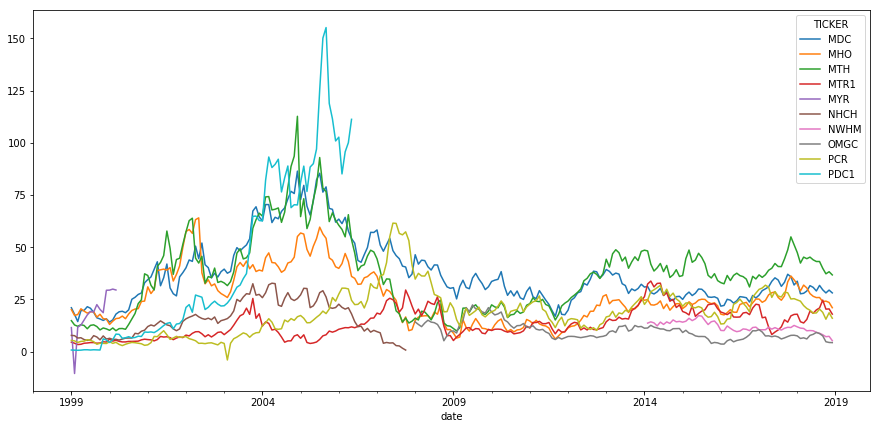

In [24]:
# Plot the price graph for a subset of the companies in the sample:
msf.pivot(index='date',columns='TICKER',values='prc').iloc[:,30:40].plot(figsize=(15,7));

### 0.5. Financial Ratios data

Here we are going to download the Financial Ratios data from WRDS Financial Ratios Suite. There are two different level of aggregation in the data:

    Firm level
    Industry level

Both are used, since Industry medians are used as benchmark.

#### 0.5.1. Firm level

In [25]:
fr = pd.read_csv('data/fr_20y.csv')

Keep only our subset of companies of interest:

In [26]:
fr = fr.loc[fr.permno.isin(msf.permno.unique())].reset_index(drop=True)

In [27]:
# And add the TICKER:
fr = fr.merge(iclink[['TICKER','PERMNO']], left_on='permno', right_on='PERMNO', how='left')

# Drop the duplicates:
fr = fr.drop(fr[fr.TICKER == 'EIC'].index)
fr = fr.drop(fr[fr.TICKER == 'BHS'].index)

# Drop permno columns:
fr.drop(['PERMNO','permno'], axis=1, inplace=True)

# Set the date fields as timestamp:
fr.public_date = pd.to_datetime(fr.public_date, format="%d/%m/%Y")

# Save fr of construction stocks:
fr.to_csv('data/fr_20y_cs.csv')

In [29]:
print('Interval of time covered: %s to %s' % (min(fr.public_date),max(fr.public_date)))
print('Number of Companies covered: %s' % fr.TICKER.nunique())
print('Shape of the dataset: %s' % str(fr.shape))

Interval of time covered: 1999-01-31 00:00:00 to 2018-12-31 00:00:00
Number of Companies covered: 57
Shape of the dataset: (7960, 75)


#### 0.5.2. Industry level

Here I load the industry aggreagted data with Fama-French 49 industry classification, with our group of interest being: Construction: (CNSTR) and aggregated as the median.

In [30]:
# Load the file:
fr_ind = pd.read_csv('data/fr_ind_20y.csv')

# Keep only construction industry data:
fr_ind = fr_ind.loc[fr_ind.FFI49_desc == 'CNSTR']

# Set the date fields as timestamp:
fr_ind.public_date = pd.to_datetime(fr_ind.public_date, format="%d/%m/%Y")

# Keep columns of interest:
fr_ind.drop(['NFIRM','FFI49_desc'],axis=1,inplace=True)

In [31]:
print('Interval of time covered: %s to %s' % (min(fr_ind.public_date),max(fr_ind.public_date)))
print('Shape of the dataset: %s' % str(fr_ind.shape))

Interval of time covered: 1999-01-31 00:00:00 to 2018-12-31 00:00:00
Shape of the dataset: (240, 74)


In [32]:
# Take away the median part of the name:
fr_ind.columns = [c.replace('_Median', '') for c in fr_ind.columns]

### 0.6. Create the master table

We are going to create the mastertable from the summary statistics file. First we just keep the last consensus before the ANNDT_ACT:

In [33]:
# Keep only FPI=6:
cons = sumstat.loc[sumstat.FPI == 6]

# Drop columns that I do not need:
cons.drop(['FPI'], axis=1, inplace=True)

# Keep the latest STATPERS for each TICKER-FPEDATS:
cons = cons.loc[cons.groupby(['TICKER','FPEDATS'])['STATPERS'].idxmax()]
cons = cons.reset_index(drop=True)

/home/eric/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# Create table with one entry per company and ACTUAL:
master = cons[['TICKER','FPEDATS','ANNDT_ACT','ACTUAL','STATPERS','MEDEST']]

# Add year for merging purposes:
master['year'] = master['FPEDATS'].dt.year

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [35]:
# Print number of companies according to each ID:
print('Number of unique TICKER: %s' % master.TICKER.nunique())
print('Master table shape: %s' % str(master.shape))

Number of unique TICKER: 57
Master table shape: (2300, 7)


In [36]:
master.head()

,TICKER,FPEDATS,ANNDT_ACT,ACTUAL,STATPERS,MEDEST,year
0,001K,2014-03-31,2014-05-13,0.02,2014-04-17,-0.01,2014
1,001K,2014-06-30,2014-08-12,0.11,2014-07-17,0.10,2014
2,001K,2014-09-30,2014-11-12,0.20,2014-10-16,0.20,2014
3,001K,2014-12-31,2015-03-04,0.20,2015-02-19,0.20,2014
4,001K,2015-03-31,2015-05-12,0.05,2015-04-16,0.09,2015


## 1. Developing the target variable

Here I am going to define the target variable, the normlaized Forecast Error:

    FE_iq = (e_iq - E(e_iq)) / (|e_iq| + |E(_iq)|)

In [37]:
master['FE'] = (master.ACTUAL - master.MEDEST)/(abs(master.ACTUAL) + abs(master.MEDEST))

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
# Let's see the summary:
master['FE'].describe().to_frame()

,FE
count,2300.000000
mean,-0.017728
std,0.341428
min,-1.000000
25%,-0.054102
50%,0.029344
75%,0.095238
max,1.000000


And now let's categorize it in the following way:

    - 1 if Zscore less than -0,5
    - 2 if Zscore less € [-0,5,0,5]
    - 3 if Zscore more than 0.5

In [39]:
# Compute Zscore of FE:
master['Zscore'] = (master.FE - master.FE.mean())/master.FE.std(ddof=0)

# Categorize the Zscore of FE:
cond = [(master.Zscore <= -0.5), (master.Zscore >= 0.5)]
group = [1,3]

master['FEC'] = np.select(cond, group, default=2)

# Drop unnecessary variables:
master.drop(['FE','Zscore'], axis=1, inplace=True)

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


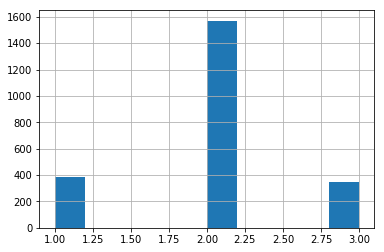

In [40]:
master.FEC.hist();

## 2. Feature Development: Market data & Expectations

Here in this section several features are developed from market data and investors expectations based on the ones that proved useful in the previous model by the author.

### 2.1. Firm Size

Firms' size is negatively correlated with the magnitud of the earnings' surprise:

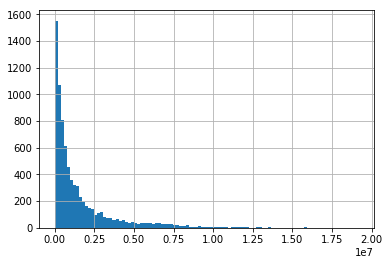

In [41]:
# Keep just size:
size = msf[['TICKER','date','year','size']]
size['size'].hist(bins=100);

Compute the size percentile rank:

In [42]:
# Compute the Size percentile rank:
size['size_pct'] = size['size'].rank(pct=True)

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


And a size grouping:

In [43]:
# Average size of each company per year:
size_group = size.groupby(['year','TICKER'], as_index=False).mean()[['year','TICKER','size']]

# Create size groups:
size_group['size_group'] = 1 + size_group['size'].transform(lambda x: pd.qcut(x, 3, labels=False))

# Merge size groups:
size = size.merge(size_group[['year','TICKER','size_group']],
           on=['year','TICKER'],
           how='left')

In [44]:
# Drop size and year:
size.drop(['size','year'],axis=1,inplace=True)

And merge back to master:

In [45]:
# Merge the size:
master = master.merge(size, left_on=['TICKER','FPEDATS'], right_on=['TICKER','date'], how='left')
master.drop(['date'], axis=1, inplace=True)

In [46]:
# Impute the NaN by 0.5 in size_pct and by 2 in size_group:
master['size_pct'] = master['size_pct'].fillna(value = 0.5)
master['size_group'] = master['size_group'].fillna(value = 2)

### 2.2. Analyst Forecast Differences

This feature proved to be somehow significant in the previosu model, and gives us information regarding the consensus changes heading towards the EAD. It is defined as:

    AFD = NUMUP - NUMDOWN
    
And it's included for 1,2 and 3 months prior to the EAD.

In [47]:
# Make copy:
st = sumstat.copy()

# Drop columns that I do not need:
st.drop(['FPI'], axis=1, inplace=True)

# Keep only the consensus when STATPERS preceeds FPEDATS:
st = st.loc[st.STATPERS < st.FPEDATS]

# Create HZN:
st['HZN'] = (st.FPEDATS - st.STATPERS)/np.timedelta64(1,'D')
st['HZN'] = st['HZN'].astype('int')

In [48]:
# Create AFD:
st['AFD'] = st.NUMUP - st.NUMDOWN

In [49]:
# Create it for different horizons:

# -1 month:
m1 = st.loc[st.HZN < 30][['FPEDATS','TICKER','AFD']]
m1.columns = ['FPEDATS','TICKER','AFD1']

# -2 month:
m2 = st[(st.HZN > 30) & (st.HZN < 60)][['FPEDATS','TICKER','AFD']]
m2.columns = ['FPEDATS','TICKER','AFD2']

# -3 month:
m3 = st.loc[(st.HZN > 60) & (st.HZN < 90)][['FPEDATS','TICKER','AFD']]
m3.columns = ['FPEDATS','TICKER','AFD3']

In [50]:
# Merge it back to the master:
master = master.merge(m1, on=['FPEDATS','TICKER'], how='left')
master = master.merge(m2, on=['FPEDATS','TICKER'], how='left')
master = master.merge(m3, on=['FPEDATS','TICKER'], how='left')

Here I will deal with NaN by filling by 0, which means no Analyst Review:

In [51]:
master[['AFD1','AFD2','AFD3']] = master[['AFD1','AFD2','AFD3']].fillna(value = 0,axis=1)

### 2.3. Past surprises information

Here I introduce the surprises in the past 4 quarters as variables:

In [52]:
# Create FEC lagged of past 4 quarters:
master['FECq1'] = master.groupby('TICKER').FEC.shift(1)
master['FECq2'] = master.groupby('TICKER').FEC.shift(2)
master['FECq3'] = master.groupby('TICKER').FEC.shift(3)
master['FECq4'] = master.groupby('TICKER').FEC.shift(4)

Drop the first 4 rows for each firm to avoid the NAs:

In [53]:
master = master.groupby('TICKER').apply(lambda firm: firm.iloc[4:,1:]).reset_index()
master.drop('level_1',axis=1,inplace=True)

In [54]:
# Change format to integer:
past_sur = ['FECq1','FECq2','FECq3','FECq4']
master[past_sur] = master[past_sur].astype('int')

In [55]:
## I lose 5 firms

## 3. Feature Development: Global Risk Factors

The following variables have been engineered to reflect the macroeconomic and geopolitical risks a construction firm is exposed to, thus as predictors of the company’s financial performance.

### 3.1. Gross National Income

Here I import using the Quandl API the GNI data form the FRED.
The data is in current USD, year frequency and not seasonally adjusted.

Source: https://www.quandl.com/data/FRED/MKTGNIUSA646NWDB

In [56]:
gni = quandl.get("FRED/MKTGNIUSA646NWDB",
                   collapse='monthly',
                   start_date='1998-01-01',
                   end_date='2018-12-31')


# Set Date as datetime object and col name:
gni.index = pd.to_datetime(gni.index, format="%d/%m/%Y")
gni.columns = ['gni']

Compute the year-on-year percentual change and merge to master:

In [57]:
# Compute the pct change:
gni['gni_yoy'] = gni.pct_change(freq='12M')

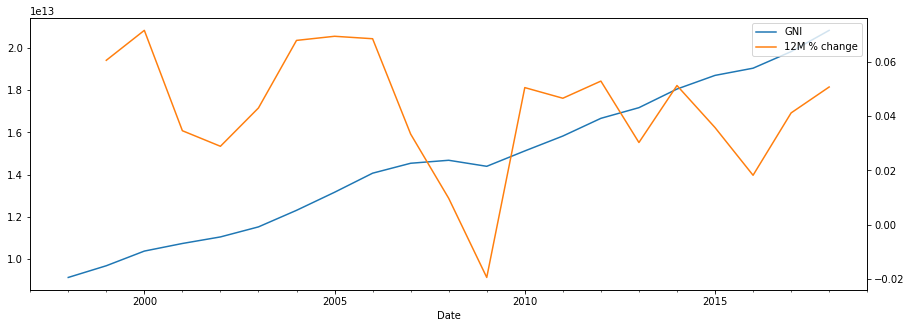

In [58]:
plt.figure(figsize=(15,5))

ax1 = gni.gni.plot(label='GNI')
ax2 = gni.gni_yoy.plot(secondary_y=True, label='12M % change')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [59]:
gni.reset_index(inplace=True)

# Add year column:
gni['year'] = gni['Date'].dt.year

# Merge by year:
master = master.merge(gni[['year','gni_yoy']], on=['year'], how='left')

### 3.2. Interest rates

Here I am going to use the 1 year Treasury Bill as Interest Rate indicator.

Source: https://www.quandl.com/data/USTREASURY/YIELD

In [60]:
# Get data from FRED:
ir = quandl.get("USTREASURY/YIELD.5",
                   collapse='monthly',
                   start_date='1998-01-01',
                   end_date='2018-12-31')

# Set the date fields as timestamp:
ir.index = pd.to_datetime(ir.index, format="%d/%m/%Y")

# Set names:
ir.columns = ['tbill1Y']

# Divide by 100 cause its in percentage:
ir.tbill1Y = ir.tbill1Y/100

Compute the last 12M percentage change:

In [61]:
ir['tbill1Y_yoy'] = ir['tbill1Y'].pct_change(freq='12M')

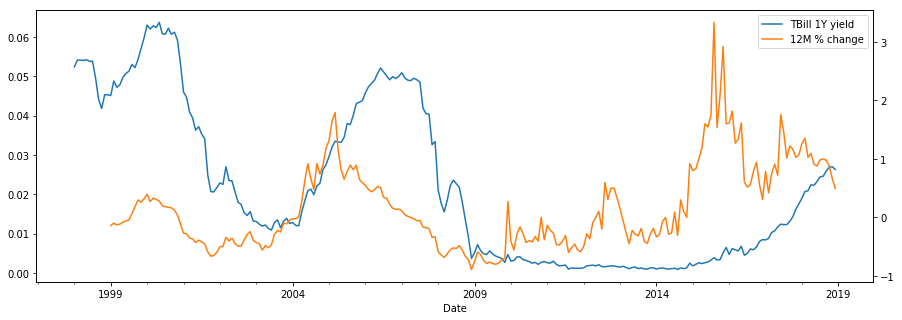

In [62]:
plt.figure(figsize=(15,5))

ax1 = ir.tbill1Y.plot(label='TBill 1Y yield')
ax2 = ir.tbill1Y_yoy.plot(secondary_y=True, label='12M % change')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [63]:
# Reset index:
ir.reset_index(inplace=True)

# Merge back:
master = master.merge(ir[['Date','tbill1Y_yoy']],
                      left_on=['FPEDATS'],
                      right_on=['Date'],
                      how='left')

# Drop date:
master.drop(['Date'], axis=1, inplace=True)

### 3.3. PPI: Construction Materials and Machinery

Here I import directly from the FRED the following PPIs data:

    Producer Price Index by Commodity for Special Indexes: Construction Materials
    Producer Price Index by Commodity for Machinery and Equipment: Construction Machinery and Equipment
    

The data has monthly frequency and not seasonally adjusted.


Source: https://fred.stlouisfed.org/graph/?id=WPUSI012011,WPU112

In [64]:
# Load the data from FRED:
ppi = pd.read_csv('data/fred_cons_mat_20y.csv')

# And rename the columns:
ppi.columns = ['date','ppi_mat','ppi_mach']

# Set as datetime object:
ppi.date = pd.to_datetime(ppi.date, format="%Y-%m-%d") + MonthEnd(-1)
ppi.set_index('date', inplace=True)

# Aquí estoy cogiendo el final del mes anterior, dado que estan hechas a primero de mes

In [65]:
# Compute the pct change in the last 12 months:
ppi['ppi_mat'] = ppi['ppi_mat'].pct_change(freq='12M')
ppi['ppi_mach'] = ppi['ppi_mach'].pct_change(freq='12M')

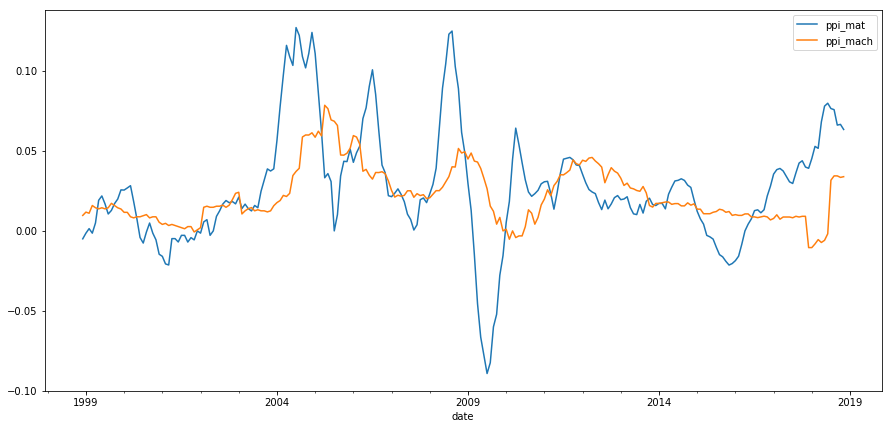

In [66]:
#ppi.set_index('date').plot(figsize=[15,7]);
ppi[['ppi_mat','ppi_mach']].plot(figsize=[15,7]);

In [67]:
# Reset index:
ppi.reset_index(inplace=True)

# Merge back:
master = master.merge(ppi[['date','ppi_mat','ppi_mach']],
                      left_on=['FPEDATS'],
                      right_on=['date'],
                      how='left')

# Drop date:
master.drop(['date'], axis=1, inplace=True)

### 3.4. Construction Spending

Here I import directly from the FRED the following Construction Spending data:

    Total Construction Spending
    Total Private Construction Spending
    Total Public Construction Spending
    

The data is in Million USD, has monthly frequency and has been seasonally adjusted with annual rate.

Source: https://fred.stlouisfed.org/graph/?id=TTLCONS,TLPRVCONS,TLPBLCONS

In [68]:
# Load the data:
cs = pd.read_csv('data/fred_cons_spe_20y.csv')

# And rename the columns:
cs.columns = ['date','total','private','public']

# Set as datetime object:
cs.date = pd.to_datetime(cs.date, format="%Y-%m-%d") + MonthEnd(-1)
cs.set_index('date', inplace=True)

In [69]:
# Compute the pct change in the last 12 months:
cs['cs_pub'] = cs['public'].pct_change(freq='12M')
cs['cs_pri'] = cs['private'].pct_change(freq='12M')

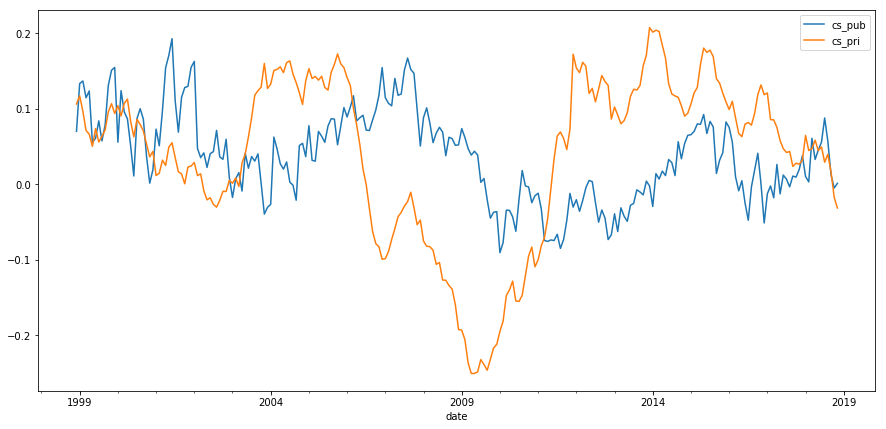

In [70]:
#cs.set_index('date')[['total',public','private']].plot(figsize=[15,7]);
cs[['cs_pub','cs_pri']].plot(figsize=[15,7]);

In [71]:
# Reset index:
cs.reset_index(inplace=True)

# Merge back:
master = master.merge(cs[['date','cs_pub','cs_pri']],
                      left_on=['FPEDATS'],
                      right_on=['date'],
                      how='left')

# Drop date:
master.drop(['date'], axis=1, inplace=True)

### 3.5. Construction Employment

Here I import directly from the FRED the following Construction Employment data:

     Average Hourly Earnings of All Employees: Construction (dollars per hour)
     Unemployment Rate: Construction Industry, Private Wage and Salary Workers (percent)
     Civilian Unemployment Rate (percent)
     
The first one will be included as an indicator of labor costs, and the next two are combined into the unemp_excess variable.

All time series have monthly frequency. The Avg Wage is in USD per hour and seasonally adjusted. The unemployment data is in percentage and not seasonally adjusted. The time series do not cover all the sample duration.

Source: https://fred.stlouisfed.org/graph/graph-landing.php?g=pV5u&width=670&height=475

In [72]:
# Load the data:
ce = pd.read_csv('data/fred_cons_emp_20y.csv')

# And rename the columns:
ce.columns = ['date','avg_hourly_earnings','unemp_cons','unemp_us']

# Set as datetime object:
ce.date = pd.to_datetime(ce.date, format="%Y-%m-%d") + MonthEnd(-1)
ce.set_index('date', inplace=True)

# Replace with NaN:
ce.replace(to_replace='.', value=np.nan, inplace=True)

# Change format:
ce[['avg_hourly_earnings','unemp_cons']] = ce[['avg_hourly_earnings','unemp_cons']].astype('float')

Let's express the unemployment as excess of the us one, this will eliminate common trends and seasonality; and then compute the yoy change:

In [73]:
# Calculate the unemployment excess:
ce['unemp_excess'] = ce.unemp_cons - ce.unemp_us

# Compute the pct change of the last year:
ce['unemp_excess_yoy'] = ce.unemp_excess.pct_change(freq='12M')

In [74]:
# There are 2 inf, replace by NaN:
ce.replace(np.inf, np.nan, inplace=True)

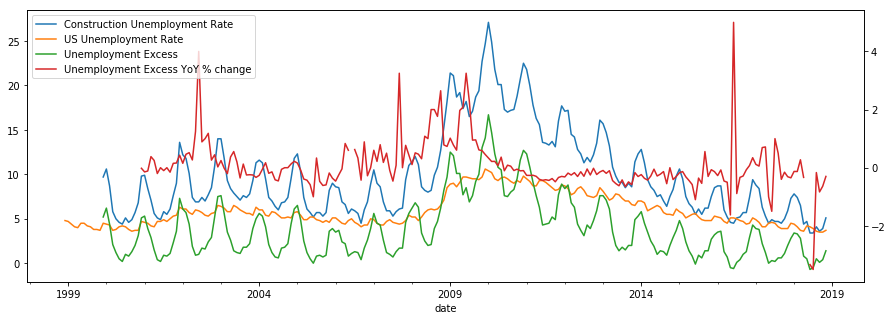

In [75]:
plt.figure(figsize=(15,5))

ax1 = ce.unemp_cons.plot(label='Construction Unemployment Rate')
ax2 = ce.unemp_us.plot(label='US Unemployment Rate')
ax3 = ce.unemp_excess.plot(label='Unemployment Excess')
ax4 = ce.unemp_excess_yoy.plot(secondary_y=True, label='Unemployment Excess YoY % change')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax4.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [76]:
# Reset index:
ce.reset_index(inplace=True)

# Merge back:
master = master.merge(ce[['date','unemp_excess_yoy']],
                      left_on=['FPEDATS'],
                      right_on=['date'],
                      how='left')

# Drop date:
master.drop(['date'], axis=1, inplace=True)

There are a few NAs as a result that the unemployment data series for construction employees start on the 2000. I am going to impute the values using the mean to not lose the data.

In [77]:
master.fillna(value=master.unemp_excess_yoy.mean(),axis=1,inplace=True)

### 3.6. Political Risk: WGI for Political Inestability

Here I import using the Quandl API from the Worl Bank the Political Stability and Absence of Violence/Terrorism WGI for the United States.

Source: https://www.quandl.com/data/WWGI/USA_PV_EST

In [78]:
# Download the WGI Political Inestability indicator:
pr = quandl.get("WWGI/USA_PV_EST",
                   collapse='monthly',
                   start_date='1996-01-01',
                   end_date='2018-12-31')

# Set Date as datetime object and col name:
pr.index = pd.to_datetime(pr.index, format="%d/%m/%Y")
pr.columns = ['pr_pv']

In [79]:
# Add values missing:
pr = pr.append(pd.DataFrame(index=[pd.to_datetime('1997-12-31')]))
pr = pr.append(pd.DataFrame(index=[pd.to_datetime('1999-12-31')]))
pr = pr.append(pd.DataFrame(index=[pd.to_datetime('2001-12-31')]))
pr = pr.sort_index()

/home/eric/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [80]:
# Compute the pct change of last 3 years:
pr = pr.pct_change(freq='3Y',fill_method='ffill')

# Shift, since we only know the data from last year:
pr = pr.shift(1)

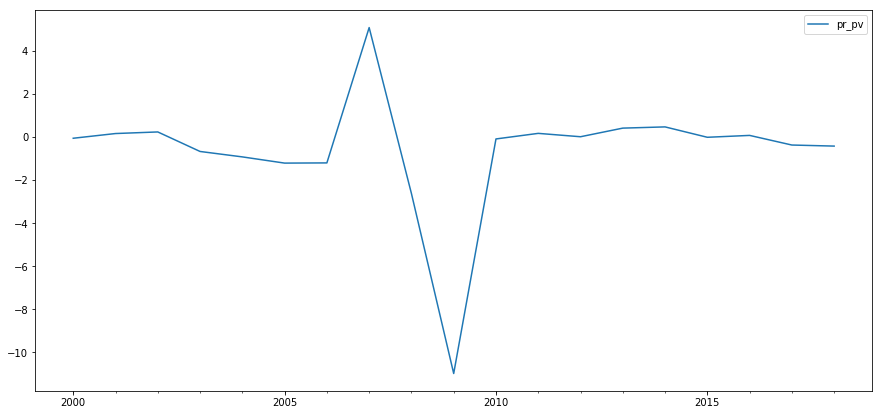

In [81]:
pr.plot(figsize=[15,7]);

And merge to master:

In [82]:
pr.reset_index(inplace=True)
pr.columns = ['date','pr_pv']

# Add year column:
pr['year'] = pr['date'].dt.year

# Merge by year:
master = master.merge(pr, on=['year'], how='left')

# Drop Date:
master.drop(['date'], axis=1, inplace=True)

## 4. Feature Development: Intrinsic Factors

The main drivers of financial distress for construction companies are
evaluated using financial ratios that proved to be relevant for construction companies’ in the literature. These metrics allow us to evaluate the following dimensions: capitalization, efficiency, financial soundness, liquidity, profitability and valuation.

### 4.1. Delay in reporting as an indicator of Financial Distress

Here I am going to add the delay in reporting earnings as an indicator of financial distress. First, I create the delay variable:

In [83]:
# Create the delay variable as days between end of de and EAD:
de = cons[['TICKER','FPEDATS', 'ANNDT_ACT']].groupby(['TICKER','FPEDATS'], as_index=False).max()
de['delay'] = (de.ANNDT_ACT - de.FPEDATS)/np.timedelta64(1,'D')
de.drop('ANNDT_ACT',axis=1,inplace=True)

print('In average firms report earnings %s days after the end of Fiscal period, with a std of %s' % (round(np.mean(de.delay.values),2),round(np.std(de.delay.values),2)))

In average firms report earnings 33.79 days after the end of Fiscal period, with a std of 13.27


Compute the normalized delay:

In [84]:
# Compute the mean and std of delay per firm:
de_st = de.groupby('TICKER').delay.agg({'mean','std'})

# Merge to delay:
de = de.merge(de_st, on=['TICKER'], how='left')

# Standarize:
de['ndelay'] = (de.delay - de['mean'])/de['std']
de.drop(['mean','std'],axis=1,inplace=True)

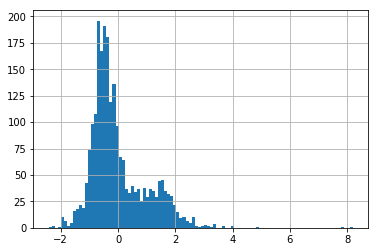

In [85]:
de['ndelay'].hist(bins=100);

Add ndelay to master:

In [86]:
# Shift since release date is not known yet on decision day:
de['ndelay'] = de['ndelay'].shift(1)

# Add to master:
master = master.merge(de[['TICKER','FPEDATS','ndelay']],
            on=['TICKER','FPEDATS'],
            how='left')

### 4.2. Financial Ratios

Here I am going to add the most relevant financial ratios to evalutate the financial performance of construction stocks based on the literature review:

In [87]:
# FR selected by subgroups:
capitalization = ['capital_ratio','intcov_ratio','de_ratio','debt_assets']
efficency = ['at_turn','inv_turn','pay_turn','rect_turn']
financial_soundness = ['cash_debt','debt_ebitda','int_totdebt','lt_debt']
liquidity = ['curr_ratio','quick_ratio']
profitability = ['npm','roa','roce','roe']
valuation = ['evm','pe_exi','ptb']

In [88]:
# Vars to keep:
fr_keep = [['TICKER','public_date'],
          capitalization,
          efficency,
          financial_soundness,
          liquidity,
          profitability,
          valuation]

# Flatten the list:
fr_keep = [val for sublist in fr_keep for val in sublist]

# Keep var subset in the firms' data:
fr = fr[fr_keep]
print('Shape of the FR firms data: %s' % str(fr.shape))

Shape of the FR firms data: (7960, 23)


In [89]:
# And in the industry data:
fr_ind = fr_ind[fr_keep[1:]]

# Add back the median:
fr_ind.columns = [c + '_Median' for c in fr_ind.columns]
fr_ind.rename(columns = {'public_date_Median':'public_date'}, inplace=True)


print('Shape of the FR industry data: %s' % str(fr_ind.shape))

Shape of the FR industry data: (240, 22)


In [90]:
# For the memory only:
np.round(fr_ind.median(),2)

capital_ratio_Median     0.38
intcov_ratio_Median      3.22
de_ratio_Median          1.28
debt_assets_Median       0.56
at_turn_Median           1.21
inv_turn_Median          5.41
pay_turn_Median         12.04
rect_turn_Median         6.32
cash_debt_Median         0.05
debt_ebitda_Median       2.24
int_totdebt_Median       0.07
lt_debt_Median           0.48
curr_ratio_Median        1.65
quick_ratio_Median       1.44
npm_Median               0.03
roa_Median               0.09
roce_Median              0.09
roe_Median               0.09
evm_Median               7.93
pe_exi_Median            8.57
ptb_Median               1.43
dtype: float64

Now add the industry median, and compute for each ratio the mean for the last 4 quarters and standarize it in the following manner:

    sfr = (fr_median - fr_industry_median)/IQR
    
First, compute the rolling window mean for each firms' FR:

In [91]:
# Set the date as index:
fr.set_index('public_date',inplace=True)

# Compute the rolling mean:
fr_ma = fr.groupby('TICKER').rolling(window=3, min_periods=1).mean().reset_index()

# Sort by company:
fr_ma.sort_values(by=['TICKER','public_date'],axis=0,inplace=True)

And benchmark it with the industry:

In [92]:
# Merge the median:
sfr = fr_ma.merge(fr_ind, on='public_date',how='left')

In [93]:
# Compute the normalized version:
for ratio in sfr.columns[2:23]:
    # Map column where median is:
    ratio_med = ratio + '_Median'
    
    # Compute IQR:
    Q1 = sfr[ratio].quantile(0.25)
    Q3 = sfr[ratio].quantile(0.75)
    IQR = Q3 - Q1
    
    # Compute normalized value:
    sfr[ratio] = (sfr[ratio] - sfr[ratio_med])/IQR

In [94]:
# Drop the Industry medians:
sfr = sfr.iloc[:,:23]

Fill the missing values with the industry median (with a 0 since standarized as (fr - ind_median)/IQR):

In [95]:
sfr.fillna(value=0,axis=1, inplace=True)

And add it to master:

In [96]:
# Merge back:
master = master.merge(sfr,
             left_on=['TICKER','FPEDATS'],
             right_on=['TICKER','public_date'],
             how='left')

# Drop date:
master.drop(['public_date'], axis=1, inplace=True)

In [97]:
# Drop BRR as there is no FR info for this firm:
master = master.loc[master.TICKER != 'BRR']

In [98]:
master.TICKER.nunique()

51

## 5. Preprocessing

Here I do some data preprocessing and check for outliers:

In [99]:
master.rename({'gni_yoy':'gni','tbill1Y_yoy':'tbill1Y','unemp_excess_yoy':'unemp_excess'},axis=1,inplace=True)

In [100]:
# Check for NAs:
master.isna().sum()

TICKER           0
FPEDATS          0
ANNDT_ACT        0
ACTUAL           0
STATPERS         0
MEDEST           0
year             0
FEC              0
size_pct         0
size_group       0
AFD1             0
AFD2             0
AFD3             0
FECq1            0
FECq2            0
FECq3            0
FECq4            0
gni              0
tbill1Y          0
ppi_mat          0
ppi_mach         0
cs_pub           0
cs_pri           0
unemp_excess     0
pr_pv            0
ndelay           0
at_turn          0
capital_ratio    0
cash_debt        0
curr_ratio       0
de_ratio         0
debt_assets      0
debt_ebitda      0
evm              0
int_totdebt      0
intcov_ratio     0
inv_turn         0
lt_debt          0
npm              0
pay_turn         0
pe_exi           0
ptb              0
quick_ratio      0
rect_turn        0
roa              0
roce             0
roe              0
dtype: int64

### 5.1. Global Risk Factors

In [101]:
# GRF vars:
grf_vars = ['gni','tbill1Y','ppi_mat','ppi_mach','cs_pub','cs_pri','unemp_excess','pr_pv']

# Descriptive statistics:
master[grf_vars].describe()

,gni,tbill1Y,ppi_mat,ppi_mach,cs_pub,cs_pri,unemp_excess,pr_pv
count,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000
mean,0.041001,0.188866,0.027644,0.022674,0.033565,0.034859,0.107256,-0.644110
std,0.022345,0.703337,0.036055,0.018447,0.057787,0.113109,1.044492,2.893797
min,-0.019469,-0.889222,-0.089104,-0.010445,-0.090775,-0.250791,-3.500000,-10.977647
25%,0.030308,-0.385542,0.009066,0.008826,-0.010366,-0.031606,-0.348837,-0.925046
50%,0.043055,0.012500,0.023344,0.017192,0.035141,0.060641,-0.099291,-0.059806
75%,0.052958,0.745763,0.042365,0.034788,0.075363,0.126735,0.343750,0.166806
max,0.071677,3.333333,0.127038,0.105690,0.192704,0.207399,5.000000,5.076408


Boxplots:

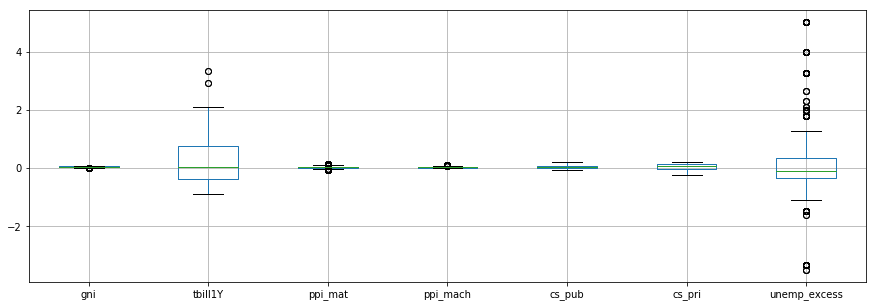

In [102]:
master.boxplot(column=grf_vars[:7],figsize=(15,5));
#master.boxplot(column='gni',figsize=(15,5));

There are no outliers comming from a potential wrong calculation to drop.

### 5.2. Intrinsic Variables: ndelay & Financial Ratios

#### 5.2.1. Ndelay

In [103]:
master.ndelay.describe()

count    2068.000000
mean        0.006775
std         0.998383
min        -2.426813
25%        -0.635844
50%        -0.314290
75%         0.493347
max         8.204051
Name: ndelay, dtype: float64

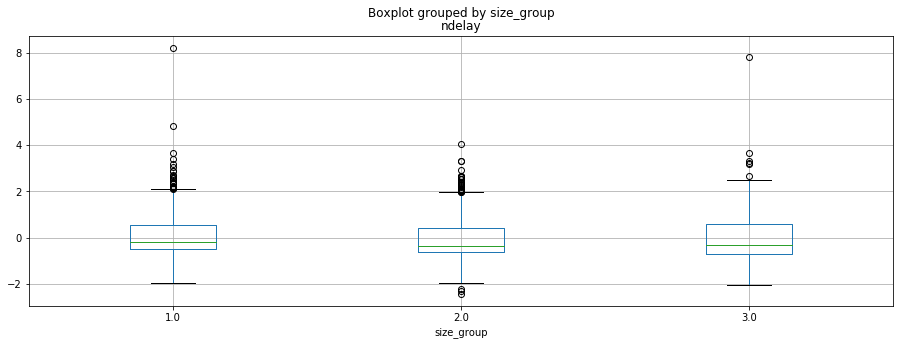

In [104]:
master.boxplot(column=['ndelay'],by='size_group',figsize=(15,5));

#### 5.2.2. Capitalization

In [105]:
master[capitalization].describe()

,capital_ratio,intcov_ratio,de_ratio,debt_assets
count,2068.000000,2068.000000,2068.000000,2068.000000
mean,0.093640,1.454745,0.092244,0.085616
std,0.758412,10.580164,2.097343,0.935076
min,-1.337259,-9.368820,-23.271429,-2.742616
25%,-0.389454,-0.213857,-0.276394,-0.345992
50%,0.117238,0.060446,0.004181,0.018987
75%,0.464936,0.847206,0.489547,0.475211
max,3.709850,415.414811,19.158537,4.770042


/home/eric/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


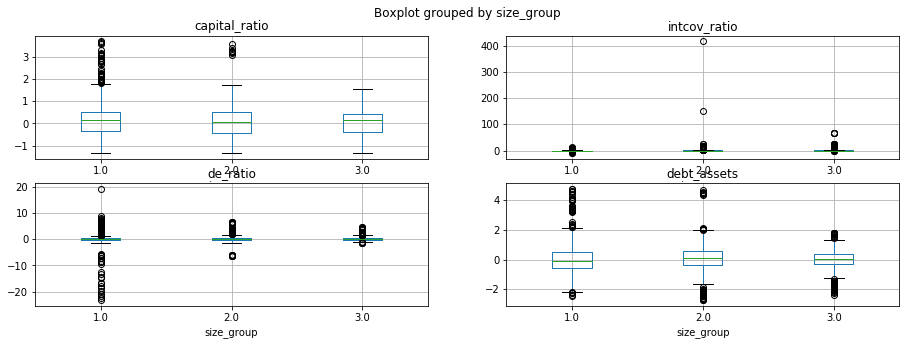

In [106]:
fig, axs = plt.subplots(2,2,figsize=(15,  5), sharey=False);
master.boxplot(capitalization, 'size_group', axs);

Drop the outlier in de_ratio:

In [107]:
master.loc[master.intcov_ratio > 100, 'de_ratio'] = 0

#### 5.2.3. Efficency

In [108]:
master[efficency].describe()

,at_turn,inv_turn,pay_turn,rect_turn
count,2068.000000,2068.000000,2068.000000,2068.000000
mean,0.160902,1.126339,0.379984,1.086732
std,0.662537,6.233262,1.049671,3.314766
min,-1.082747,-0.692995,-1.097510,-0.173511
25%,-0.348202,-0.309916,-0.220528,-0.035646
50%,0.026821,-0.085047,0.088077,0.000000
75%,0.566673,0.661246,0.632003,0.726981
max,2.519308,102.819627,10.211020,78.974411


/home/eric/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


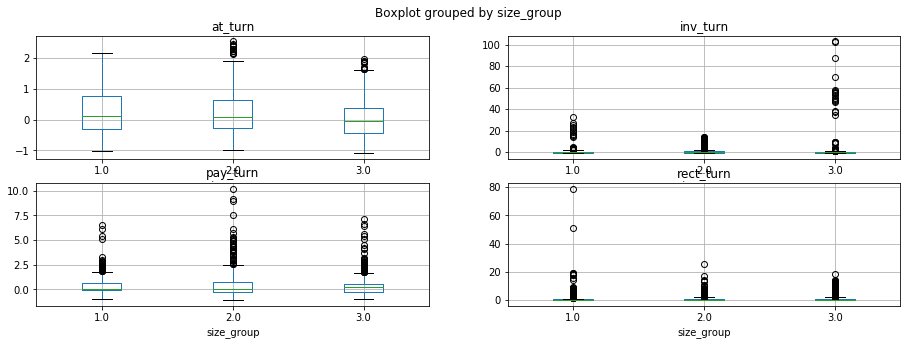

In [109]:
fig, axs = plt.subplots(2,2,figsize=(15,  5), sharey=False);
master.boxplot(efficency, 'size_group', axs);

In [110]:
master.loc[master.rect_turn > 30, 'rect_turn'] = 0

#### 5.2.4. Financial Soundness

In [111]:
master[financial_soundness].describe()

,cash_debt,debt_ebitda,int_totdebt,lt_debt
count,2.068000e+03,2068.000000,2068.000000,2068.000000
mean,3.959169e-02,-0.056511,4.028528,0.029358
std,8.975317e-01,13.427929,64.442989,0.581825
min,-7.960199e+00,-478.930157,-1.570000,-1.216642
25%,-4.440299e-01,-0.401287,-0.330000,-0.482009
50%,1.726093e-17,0.015643,0.000000,0.137181
75%,4.564677e-01,0.532075,0.460000,0.483883
max,6.019900e+00,121.924608,2303.860000,1.213643


/home/eric/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


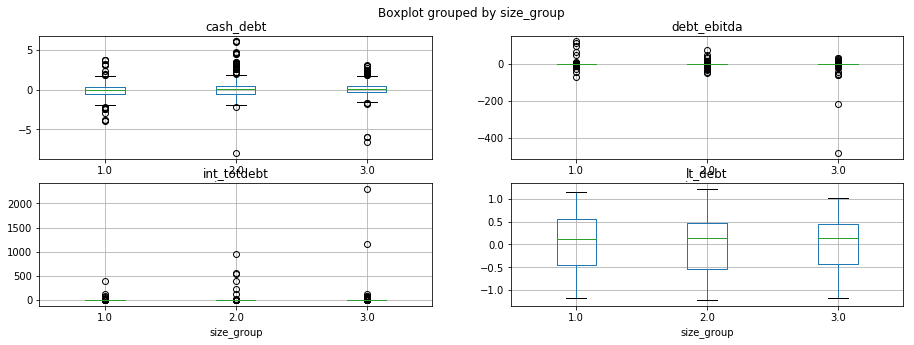

In [112]:
fig, axs = plt.subplots(2,2,figsize=(15,5), sharey=False);
master.boxplot(financial_soundness, 'size_group', axs);

In [113]:
master.loc[master.debt_ebitda < -150, 'debt_ebitda'] = 0

#### 5.2.5. Liquidity

In [114]:
# For the liquidity ratios exclude the 0 as they are imputed NAs:
liq = master[['size_group','curr_ratio','quick_ratio']]

liq = liq.loc[liq.curr_ratio != 0]
liq = liq.loc[liq.quick_ratio != 0]

In [115]:
liq[liquidity].describe()

,curr_ratio,quick_ratio
count,891.000000,891.000000
mean,0.287986,0.189504
std,0.800769,0.779252
min,-0.989772,-1.216934
25%,-0.281434,-0.298597
50%,0.024383,0.027054
75%,0.688088,0.492735
max,3.350346,3.493487


/home/eric/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


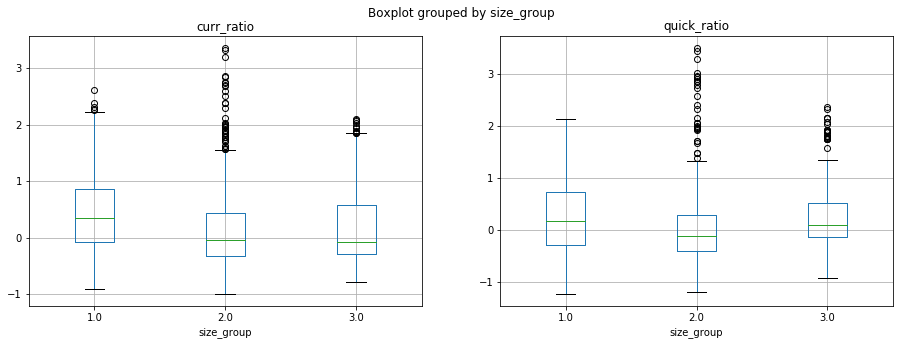

In [116]:
fig, axs = plt.subplots(1,2,figsize=(15,  5), sharey=False);
liq.boxplot(liquidity, 'size_group', axs);

#### 5.2.6. Profitability

In [117]:
master[profitability].describe()

,npm,roa,roce,roe
count,2068.000000,2068.000000,2068.000000,2068.000000
mean,-0.137836,0.106880,0.157641,-0.044785
std,1.755103,0.918932,0.963504,1.990562
min,-16.857988,-4.090343,-2.852349,-48.571678
25%,-0.344675,-0.327103,-0.259508,-0.243444
50%,0.177515,0.096573,0.102908,0.111014
75%,0.621302,0.588785,0.543624,0.534965
max,7.739645,4.392523,6.131991,4.634615


/home/eric/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


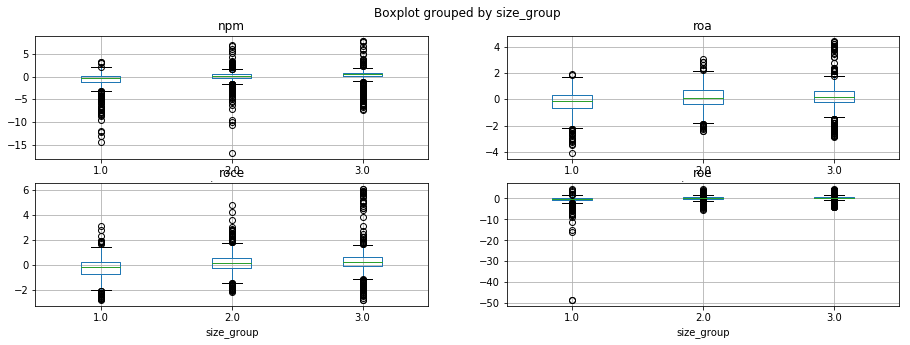

In [118]:
fig, axs = plt.subplots(2,2,figsize=(15,  5), sharey=False);
master.boxplot(profitability, 'size_group', axs);

In [119]:
master.loc[master.roe < -20, 'roe'] = 0

#### 5.2.7. Valuation

In [120]:
master[valuation].describe()

,evm,pe_exi,ptb
count,2068.000000,2068.000000,2068.000000
mean,-0.171951,0.172967,0.263462
std,12.796669,3.080681,1.100279
min,-436.908085,-38.576648,-1.690595
25%,-0.308415,-0.201509,-0.331908
50%,0.019543,0.028928,0.024843
75%,0.490671,0.558264,0.484756
max,117.967158,24.207001,9.503791


/home/eric/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


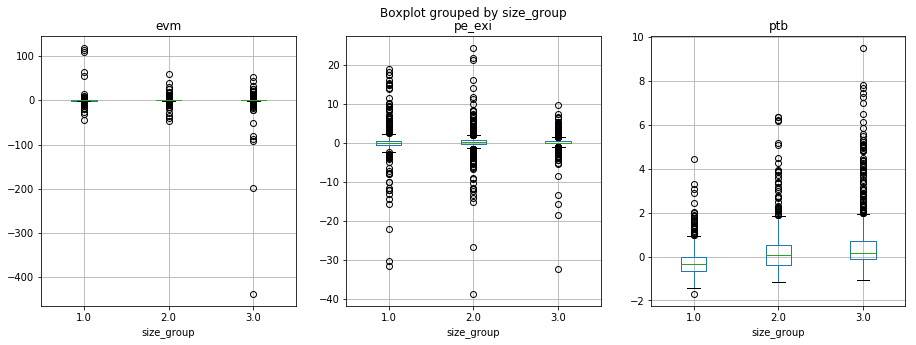

In [121]:
fig, axs = plt.subplots(1,3,figsize=(15,  5), sharey=False);
master.boxplot(valuation, 'size_group', axs);

In [122]:
master.loc[master.roe < -150, 'roe'] = 0

## 6. Train and test sets

Here I divide the data into a train and test set respecting the temporal dimension.

In [123]:
# Only train and validation 70/30:
train = master.loc[master.FPEDATS <= '31/12/2014']
test = master.loc[master.FPEDATS >= '01/01/2015']

In [124]:
print('The dimensions of the train set are: %s' % str(train.shape))
print('The dimensions of the test set are: %s' % str(test.shape))

The dimensions of the train set are: (1609, 47)
The dimensions of the test set are: (459, 47)


In [125]:
print('Interval of time covered by TRAIN: %s to %s' % (min(train.FPEDATS),max(train.FPEDATS)))
print('Interval of time covered by TEST: %s to %s' % (min(test.FPEDATS),max(test.FPEDATS)))

Interval of time covered by TRAIN: 2000-01-31 00:00:00 to 2014-12-31 00:00:00
Interval of time covered by TEST: 2015-01-31 00:00:00 to 2018-12-31 00:00:00


And save them:

In [126]:
train.to_csv('output/train.csv', index=False)
test.to_csv('output/test.csv', index=False)
msf.to_csv('output/msf_prep.csv', index=False)
master.to_csv('output/master.csv', index=False)